In [0]:
!pip install -q kaggle

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
!kaggle competitions download -c nyc-taxi-trip-duration

  0% 0.00/2.49M [00:00<?, ?B/s]
100% 2.49M/2.49M [00:00<00:00, 83.0MB/s]
 25% 5.00M/20.3M [00:00<00:02, 5.43MB/s]
100% 20.3M/20.3M [00:01<00:00, 20.0MB/s]
 91% 57.0M/62.9M [00:01<00:00, 27.6MB/s]
100% 62.9M/62.9M [00:01<00:00, 59.1MB/s]


In [0]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv('train.zip', compression='zip', header=0, sep=',', quotechar='"')

In [0]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [0]:
df = df.drop('dropoff_datetime', axis=1)

In [0]:
df = df.sort_values(by='pickup_datetime')

In [0]:
train_df, test_df = df[:10 ** 6], df[10 ** 6:]


In [0]:
len(test_df)

458644

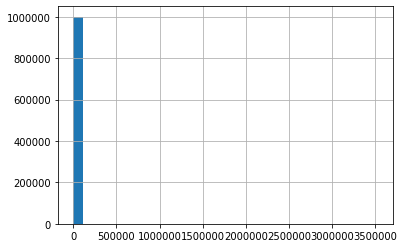

In [0]:
train_df.trip_duration.hist(bins=30)

In [0]:
import numpy as np

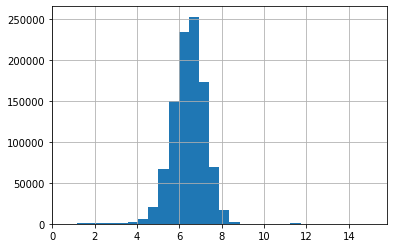

In [0]:
np.log1p(train_df.trip_duration).hist(bins=30)

In [0]:
train_df['log_trip_duration'] = np.log1p(train_df.trip_duration)
test_df['log_trip_duration'] = np.log1p(test_df.trip_duration)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
train_df.pickup_datetime = pd.to_datetime(train_df.pickup_datetime)
test_df.pickup_datetime = pd.to_datetime(test_df.pickup_datetime)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [0]:
dates = train_df.pickup_datetime.apply(lambda x: x.date())

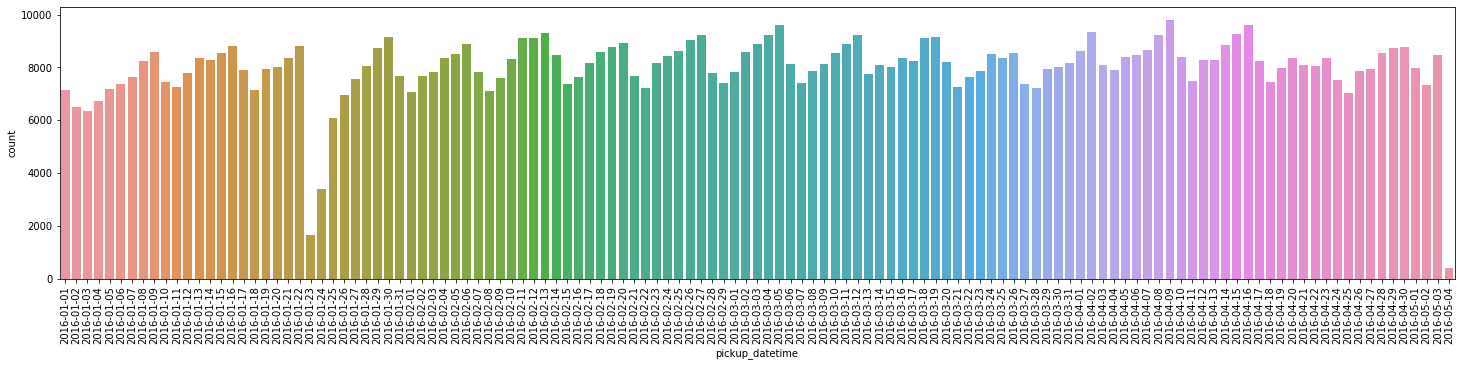

In [0]:
plt.figure(figsize=(25, 5))
data_count_plot = sns.countplot(x = dates)
data_count_plot.set_xticklabels(data_count_plot.get_xticklabels(), rotation=90);

In [0]:
group_by_date = train_df.groupby(dates)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


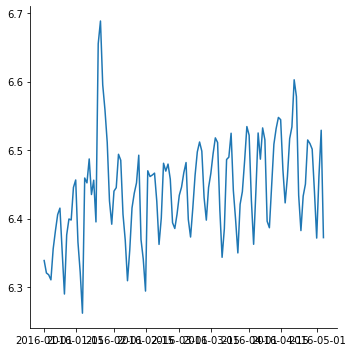

In [0]:
sns.relplot(data=group_by_date.log_trip_duration.aggregate('mean'), kind='line')

In [0]:
def create_features(data_frame):
    X = pd.concat(
        [
         data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
         data_frame.pickup_datetime.apply(lambda x: x.hour)
        ], axis=1, keys=['day', 'hour']
    )
    return X, data_frame.log_trip_duration

In [0]:
X_train, y_train = create_features(train_df)
X_test, y_test = create_features(test_df)

In [0]:
X_train.head()

,day,hour
96469,1,0
223872,1,0
713067,1,0
652463,1,0
722901,1,0


In [0]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [0]:
ohe = ColumnTransformer([("One Hot", OneHotEncoder(sparse=False), [1])], remainder='passthrough')

In [0]:
X_train = ohe.fit_transform(X_train)

In [0]:
X_train.shape

(1000000, 25)

In [0]:
X_test = ohe.transform(X_test)

In [0]:
from sklearn.linear_model import Ridge

In [0]:
from sklearn.metrics import mean_squared_error

In [0]:
ridge = Ridge(alpha=1000).fit(X_train, y_train)

In [0]:
mean_squared_error(y_test, ridge.predict(X_test))

0.6539687819760849